In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [9]:

PROJECT_ROOT = "/home/tanisha_ubuntu/Desktop/dc project/dc-vs-chess-detection/DC-chess"
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
FULL_BOARDS = os.path.join(DATA_DIR, "full_boards")
TILES_LABELED = os.path.join(DATA_DIR, "tiles_labeled")

print("Paths:")
print("Project root:", PROJECT_ROOT)
print("Full boards:", FULL_BOARDS)
print("Labeled tiles:", TILES_LABELED)


Paths:
Project root: /home/tanisha_ubuntu/Desktop/dc project/dc-vs-chess-detection/DC-chess
Full boards: /home/tanisha_ubuntu/Desktop/dc project/dc-vs-chess-detection/DC-chess/data/full_boards
Labeled tiles: /home/tanisha_ubuntu/Desktop/dc project/dc-vs-chess-detection/DC-chess/data/tiles_labeled


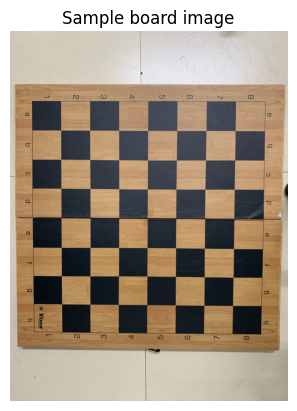

In [11]:

import os, cv2, numpy as np
import matplotlib.pyplot as plt
from PIL import Image

PROJECT_ROOT = os.getcwd()
FULL_BOARDS = os.path.join(os.getcwd(), "..", "data", "full_boards")

sample_fname = "IMG_1336.jpg"
if sample_fname:
    img_path = os.path.join(FULL_BOARDS, sample_fname)
    img = cv2.imread(img_path)
    if img is None:
        img = np.array(Image.open(img_path).convert('RGB'))[:, :, ::-1]
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Sample board image")
    plt.axis("off")
    plt.show()
else:
    print("Set 'sample_fname' to test visualization.")


Auto-detect failed on downscaled image.


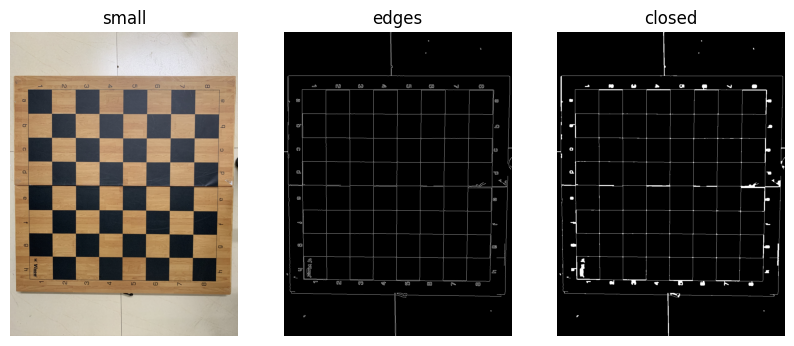

Auto-detect failed — try manual picker (next cell).


In [1]:
# %%
import cv2, numpy as np, os
import matplotlib.pyplot as plt
from PIL import Image

def fast_detect_board_and_warp(img_bgr, debug=False, target_width=900):
    # Keep original
    H0, W0 = img_bgr.shape[:2]

    # downscale for faster processing while preserving aspect
    scale = min(1.0, target_width / float(W0))
    small = cv2.resize(img_bgr, (int(W0*scale), int(H0*scale)))
    gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # stronger edges sometimes needed
    edged = cv2.Canny(blur, 40, 120)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    board_approx = None
    for c in sorted(contours, key=cv2.contourArea, reverse=True)[:20]:  # only top 20 by area
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            board_approx = approx.reshape(4,2)
            break

    if board_approx is None:
        if debug:
            print("Auto-detect failed on downscaled image.")
            plt.figure(figsize=(10,4))
            plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(small, cv2.COLOR_BGR2RGB)); plt.title('small'); plt.axis('off')
            plt.subplot(1,3,2); plt.imshow(edged, cmap='gray'); plt.title('edges'); plt.axis('off')
            plt.subplot(1,3,3); plt.imshow(closed, cmap='gray'); plt.title('closed'); plt.axis('off')
            plt.show()
        return None, None

    # scale points back to original image coordinates
    board_pts_orig = (board_approx / scale).astype(np.float32)

    # order points (tl,tr,br,bl)
    s = board_pts_orig.sum(axis=1)
    tl = board_pts_orig[np.argmin(s)]
    br = board_pts_orig[np.argmax(s)]
    diff = np.diff(board_pts_orig, axis=1)
    tr = board_pts_orig[np.argmin(diff)]
    bl = board_pts_orig[np.argmax(diff)]
    rect = np.array([tl,tr,br,bl], dtype='float32')

    # perspective transform
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))
    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0,maxHeight-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img_bgr, M, (maxWidth, maxHeight))
    size = max(warped.shape[:2])
    warped_sq = cv2.resize(warped, (size, size))
    return warped_sq, rect

# --- run it ---
# set your sample name and full path (as you've been doing)
try:
    sample_fname
except NameError:
    sample_fname = "IMG_1336.jpg"
cwd = os.getcwd()
if cwd.endswith("notebooks"):
    PROJECT_ROOT = os.path.abspath(os.path.join(cwd, ".."))
else:
    PROJECT_ROOT = cwd
FULL_BOARDS = os.path.join(PROJECT_ROOT, "data", "full_boards")
img_path = os.path.join(FULL_BOARDS, sample_fname)

img = cv2.imread(img_path)
if img is None:
    img = np.array(Image.open(img_path).convert('RGB'))[:, :, ::-1]

warped, rect = fast_detect_board_and_warp(img, debug=True, target_width=900)
if warped is None:
    print("Auto-detect failed — try manual picker (next cell).")
else:
    plt.figure(figsize=(6,6)); plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)); plt.title('Warped (fast)'); plt.axis('off'); plt.show()
    out_dir = os.path.join(PROJECT_ROOT, "data", "processed")
    os.makedirs(out_dir, exist_ok=True)
    outpath = os.path.join(out_dir, f"{os.path.splitext(sample_fname)[0]}_warped_fast.jpg")
    cv2.imwrite(outpath, warped)
    print("Saved warped image to:", outpath)


In [2]:
def order_points_clockwise(pts):
    rect = np.zeros((4,2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points_clockwise(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))
    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0,maxHeight-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

def detect_board_and_warp(img, debug=True):
    orig = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edged = cv2.Canny(blur, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    board_cnt = None
    approx = None
    for c in sorted(contours, key=cv2.contourArea, reverse=True):
        peri = cv2.arcLength(c, True)
        approx_c = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx_c) == 4:
            board_cnt = c
            approx = approx_c.reshape(4,2)
            break

    if debug:
        # show original, edged, closed
        plt.figure(figsize=(14,6))
        plt.subplot(1,3,1); plt.title("Original"); plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)); plt.axis('off')
        plt.subplot(1,3,2); plt.title("Edges (Canny)"); plt.imshow(edged, cmap='gray'); plt.axis('off')
        plt.subplot(1,3,3); plt.title("Closed"); plt.imshow(closed, cmap='gray'); plt.axis('off')
        plt.show()

    if board_cnt is None:
        if debug:
            print("⚠️ Board not found by automatic contour detection.")
        return None, None

    # draw the chosen contour on a copy
    overlay = orig.copy()
    cv2.drawContours(overlay, [board_cnt], -1, (0,255,0), 4)
    # draw approx corners
    for (x,y) in approx:
        cv2.circle(overlay, (int(x), int(y)), 8, (255,0,0), -1)

    plt.figure(figsize=(7,7))
    plt.title("Detected board contour + corners")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    warped = four_point_transform(orig, approx)
    # make square and resize to a nice size (e.g., 1024)
    h,w = warped.shape[:2]
    size = max(h,w)
    warped_square = cv2.resize(warped, (size, size))
    plt.figure(figsize=(6,6))
    plt.title("Warped (flattened) board")
    plt.imshow(cv2.cvtColor(warped_square, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return warped_square, approx


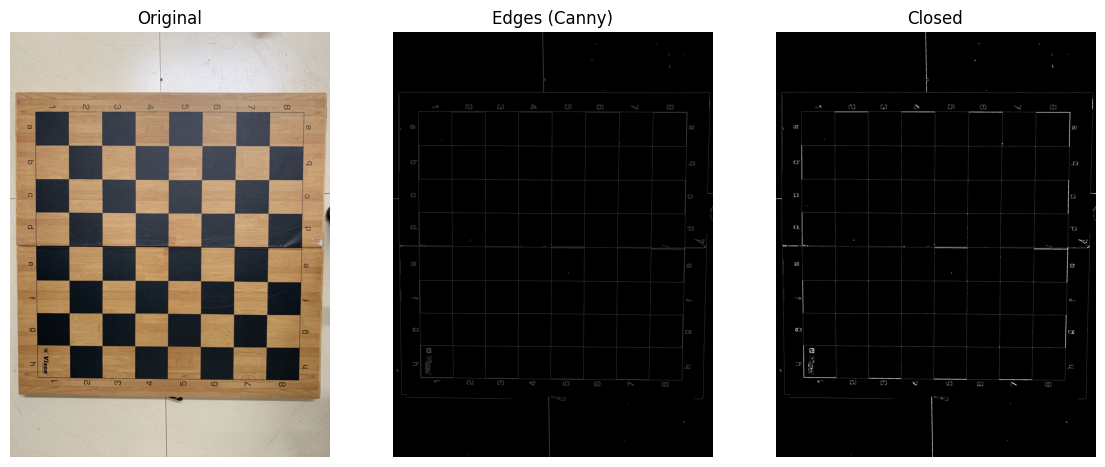

⚠️ Board not found by automatic contour detection.
Auto-detection failed. Run manual corner selection cell.


In [20]:
try:
    sample_fname  # exists?
except NameError:
    sample_fname = "IMG_1336.jpg"  # change if needed
    print("sample_fname not defined earlier; using", sample_fname)

# Build full path robustly (works if running from notebooks/ or project root)
cwd = os.getcwd()
if cwd.endswith("notebooks"):
    PROJECT_ROOT = os.path.abspath(os.path.join(cwd, ".."))
else:
    PROJECT_ROOT = cwd
FULL_BOARDS = os.path.join(PROJECT_ROOT, "data", "full_boards")
img_path = os.path.join(FULL_BOARDS, sample_fname)

if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image not found: {img_path}")

img = cv2.imread(img_path)
if img is None:
    img = np.array(Image.open(img_path).convert('RGB'))[:, :, ::-1]

warped, approx_pts = detect_board_and_warp(img, debug=True)

# save warped for later cells
if warped is not None:
    os.makedirs(os.path.join(PROJECT_ROOT, "data", "processed"), exist_ok=True)
    save_path = os.path.join(PROJECT_ROOT, "data", "processed", f"{os.path.splitext(sample_fname)[0]}_warped.jpg")
    cv2.imwrite(save_path, warped)
    print("Warped board saved to:", save_path)
else:
    print("Auto-detection failed. Run manual corner selection cell.")

In [ ]:
# %%
# Manual corner selection using matplotlib ginput (click 4 points on the board corners)
import matplotlib.pyplot as plt
import cv2, numpy as np, os
from PIL import Image

def four_point_transform(image, pts):
    rect = np.array(pts, dtype=np.float32)
    # reuse ordering helper
    s = rect.sum(axis=1)
    tl = rect[np.argmin(s)]
    br = rect[np.argmax(s)]
    diff = np.diff(rect, axis=1)
    tr = rect[np.argmin(diff)]
    bl = rect[np.argmax(diff)]
    rect2 = np.array([tl, tr, br, bl], dtype="float32")
    (tl, tr, br, bl) = rect2
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))
    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0,maxHeight-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect2, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

# load same image as before
try:
    sample_fname
except NameError:
    sample_fname = "IMG_1336.jpg"

cwd = os.getcwd()
if cwd.endswith("notebooks"):
    PROJECT_ROOT = os.path.abspath(os.path.join(cwd, ".."))
else:
    PROJECT_ROOT = cwd
FULL_BOARDS = os.path.join(PROJECT_ROOT, "data", "full_boards")
img_path = os.path.join(FULL_BOARDS, sample_fname)

img_bgr = cv2.imread(img_path)
if img_bgr is None:
    img_bgr = np.array(Image.open(img_path).convert('RGB'))[:, :, ::-1]

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.title("Click 4 corners of the board (clockwise or anticlockwise). Then close the window.")
plt.axis('off')

# Use matplotlib ginput to let you click 4 points
pts = plt.ginput(4, timeout=0)  # blocks until 4 clicks
plt.close()
print("Points selected:", pts)

if len(pts) != 4:
    raise RuntimeError("You must click exactly 4 points. Rerun cell and click 4 corners.")

warped_manual = four_point_transform(img_bgr, pts)
size = max(warped_manual.shape[:2])
warped_manual = cv2.resize(warped_manual, (size, size))

plt.figure(figsize=(6,6)); plt.imshow(cv2.cvtColor(warped_manual, cv2.COLOR_BGR2RGB)); plt.title("Warped (manual)"); plt.axis('off'); plt.show()

# save
out_dir = os.path.join(PROJECT_ROOT, "data", "processed")
os.makedirs(out_dir, exist_ok=True)
save_path = os.path.join(out_dir, f"{os.path.splitext(sample_fname)[0]}_warped_manual.jpg")
cv2.imwrite(save_path, warped_manual)
print("Saved manual warped board to:", save_path)


/tmp/ipykernel_10322/2638323347.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pts = plt.ginput(4, timeout=0)  # blocks until 4 clicks
